In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Funcoes_auxiliares.func_aux import *
from sklearn.impute import KNNImputer

# Knowing the dataset
At first, no cleaning will be applied to the dataset, later we will apply all cleaning and make a new EDA

In [2]:
#Import dataset
df = pd.read_csv('base_suja/base_unificada_suja.csv')
variaveis = [
    'data_evento', 'ano_evento', 'TIPOBITO', 'evento_MUNNOMEX',
    'res_MUNNOMEX', 'evento_CAPITAL', 'res_CAPITAL', 'evento_REGIAO',
    'res_REGIAO', 'evento_SIGLA_UF', 'res_SIGLA_UF', 'IDADEMAE',
    'idademae_faixa', 'ESCMAE2010', 'escolaridade_mae', 'OBITOGRAV',
    'GRAVIDEZ', 'tipo_gravidez', 'SEMAGESTAC', 'idade_gestacao_faixa',
    'SEXO', 'def_sexo', 'PESO', 'peso_faixa', 'OBITOPARTO',
    'def_obito_parto', 'CAUSABAS', 'causabas_capitulo',
    'causabas_categoria', 'causabas_grupo', 'causabas_subcategoria',
    'FLAG_BASE', 'sum_CENTROBS', 'sum_QTINST34', 'sum_QTINST35',
    'sum_QTINST36', 'sum_QTINST37', 'sum_QTLEIT34', 'sum_QTLEIT38',
    'sum_QTLEIT39', 'sum_QTLEIT40', 'sum_CENTRNEO','TP_UNID_5', 'TP_UNID_7',
    'TP_UNID_15', 'TP_UNID_36', 'TP_UNID_61'
]
df = df[variaveis]

<ipython-input-2-5c667751b380>:2: DtypeWarning: Columns (25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('base_suja/base_unificada_suja.csv')


In [3]:
# Configuration to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [4]:
url_dicionario = 'https://docs.google.com/spreadsheets/d/1QFy_F2o81ULglNx8knNqg6oI7v3RARaUAaLLwOQr7K4/edit?usp=sharing'
f"""The dataset has {len(df)} lines and {len(df.columns)} columns. More details can be consulted in the dictionary {url_dicionario}. Below the type of variables and the 'face' from the dataset"""

"The dataset has 13908753 lines and 47 columns. More details can be consulted in the dictionary https://docs.google.com/spreadsheets/d/1QFy_F2o81ULglNx8knNqg6oI7v3RARaUAaLLwOQr7K4/edit?usp=sharing. Below the type of variables and the 'face' from the dataset"

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13908753 entries, 0 to 13908752
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   data_evento            object 
 1   ano_evento             int64  
 2   TIPOBITO               float64
 3   evento_MUNNOMEX        object 
 4   res_MUNNOMEX           object 
 5   evento_CAPITAL         object 
 6   res_CAPITAL            object 
 7   evento_REGIAO          object 
 8   res_REGIAO             object 
 9   evento_SIGLA_UF        object 
 10  res_SIGLA_UF           object 
 11  IDADEMAE               float64
 12  idademae_faixa         object 
 13  ESCMAE2010             float64
 14  escolaridade_mae       object 
 15  OBITOGRAV              float64
 16  GRAVIDEZ               float64
 17  tipo_gravidez          object 
 18  SEMAGESTAC             float64
 19  idade_gestacao_faixa   object 
 20  SEXO                   int64  
 21  def_sexo               object 
 22  PESO            

In [6]:
df.head()

,data_evento,ano_evento,TIPOBITO,evento_MUNNOMEX,res_MUNNOMEX,evento_CAPITAL,res_CAPITAL,evento_REGIAO,res_REGIAO,evento_SIGLA_UF,res_SIGLA_UF,IDADEMAE,idademae_faixa,ESCMAE2010,escolaridade_mae,OBITOGRAV,GRAVIDEZ,tipo_gravidez,SEMAGESTAC,idade_gestacao_faixa,SEXO,def_sexo,PESO,peso_faixa,OBITOPARTO,def_obito_parto,CAUSABAS,causabas_capitulo,causabas_categoria,causabas_grupo,causabas_subcategoria,FLAG_BASE,sum_CENTROBS,sum_QTINST34,sum_QTINST35,sum_QTINST36,sum_QTINST37,sum_QTLEIT34,sum_QTLEIT38,sum_QTLEIT39,sum_QTLEIT40,sum_CENTRNEO,TP_UNID_5,TP_UNID_7,TP_UNID_15,TP_UNID_36,TP_UNID_61
0,2018-03-18,2018,1.0,NOVA FRIBURGO,MUNICIPIO IGNORADO - RJ,N,N,Sudeste,Sudeste,RJ,RJ,19.0,menor_igual_19,3.0,Ensino_medio,NaN,1.0,Unica,31.0,entre_28_36,1,Masculino,1380.0,entre_500_1499,1.0,Antes,P200,XVI. Algumas afec originadas no período perinatal,P20 Hipoxia intra-uterina,Transt respirat e cardiovasc específ per perin...,P20.0 Hipoxia intra-uter diagn ant inic trab p...,SIM_DOFET,4.0,3.0,3.0,3.0,4.0,13.0,18.0,8.0,38.0,2.0,4.0,2.0,0.0,45.0,0.0
1,2018-03-27,2018,1.0,NOVA FRIBURGO,CACHOEIRAS DE MACACU,N,N,Sudeste,Sudeste,RJ,RJ,NaN,Ignorado,NaN,Ignorado,NaN,9.0,Ignorado,NaN,Ignorado,2,Feminino,NaN,Ignorado,9.0,Ignorado,P025,XVI. Algumas afec originadas no período perinatal,P02 Fet rec-nasc afet compl plac cord umb membr,"Fet rec-nasc afet fat mat e compl grav, trab p...",P02.5 Fet rec-nasc afet outr compr cord umbilical,SIM_DOFET,4.0,3.0,3.0,3.0,4.0,13.0,18.0,8.0,38.0,2.0,4.0,2.0,0.0,45.0,0.0
2,2018-04-09,2018,1.0,SOROCABA,SOROCABA,N,N,Sudeste,Sudeste,SP,SP,NaN,Ignorado,NaN,Ignorado,NaN,1.0,Unica,23.0,entre_22_27,2,Feminino,610.0,entre_500_1499,1.0,Antes,P010,XVI. Algumas afec originadas no período perinatal,P01 Fet rec-nasc afet complic maternas gravidez,"Fet rec-nasc afet fat mat e compl grav, trab p...",P01.0 Fet rec-nasc afet incompetencia colo ute...,SIM_DOFET,7.0,11.0,6.0,0.0,13.0,18.0,0.0,20.0,55.0,4.0,8.0,3.0,0.0,73.0,0.0
3,2018-01-01,2018,1.0,ITABORAI,ITABORAI,N,N,Sudeste,Sudeste,RJ,RJ,37.0,entre_35_39,9.0,Ignorado,NaN,1.0,Unica,31.0,entre_28_36,1,Masculino,1860.0,entre_1500_2499,1.0,Antes,A502,I. Algumas doenças infecciosas e parasitárias,A50 Sifilis congen,Infecções de transmissão predominantemente sexual,A50.2 Sifilis congen precoce NE,SIM_DOFET,1.0,2.0,1.0,0.0,0.0,4.0,0.0,2.0,22.0,1.0,3.0,1.0,0.0,16.0,0.0
4,2018-01-09,2018,1.0,ITABORAI,ITABORAI,N,N,Sudeste,Sudeste,RJ,RJ,24.0,entre_20_34,4.0,Ensino_superior,NaN,1.0,Unica,23.0,entre_22_27,2,Feminino,680.0,entre_500_1499,1.0,Antes,P012,XVI. Algumas afec originadas no período perinatal,P01 Fet rec-nasc afet complic maternas gravidez,"Fet rec-nasc afet fat mat e compl grav, trab p...",P01.2 Fet rec-nasc afetados p/oligohidramnio,SIM_DOFET,1.0,2.0,1.0,0.0,0.0,4.0,0.0,2.0,22.0,1.0,3.0,1.0,0.0,16.0,0.0


#  Checking data quality

### Duplicates

In [7]:
# Duplicate data 
duplicados = df.duplicated()
soma = duplicados.sum()
f"""The dataset has {soma} duplicate rows, which represents {round((soma/len(df)) * 100, 2)} %"""

'The dataset has 3908 duplicate rows, which represents 0.03 %'

In [8]:
# Frequency of duplicates by FLAG_BASE, res_SIGLA_UF and ano_evento
df_duplicados = df[duplicados]
df_duplicados.value_counts(['FLAG_BASE', 'ano_evento', 'res_SIGLA_UF'])

# There is no concentration of missing items that indicates a structural problem with filling in the data, whether by year or 
# UF of residence

FLAG_BASE  ano_evento  res_SIGLA_UF
SINASC     2018        SP              311
           2019        SP              292
           2020        SP              271
           2021        SP              226
           2022        SP              220
           2018        RJ               76
           2019        RJ               73
           2022        RJ               71
           2021        RJ               68
           2020        RJ               64
           2019        MG               52
           2020        MG               51
           2021        MG               47
           2018        CE               45
                       PA               45
                       MG               44
           2022        MG               41
           2021        CE               40
                       MA               36
           2019        AL               35
           2021        PE               34
                       BA               34
                  

### Missing

In [9]:
# Counting missing values
df_sim_dofet = df[df['FLAG_BASE']=='SIM_DOFET']
missing_count_sim_dofet = df_sim_dofet.isnull().sum()  # counts the null values in each column
missing_percent_sim_dofet = round((missing_count_sim_dofet / len(df_sim_dofet)) * 100,2)  # calculates the percentage of null values
missing_data_sim_dofet = pd.DataFrame({'Missing Count': missing_count_sim_dofet, 'Missing Percentage': missing_percent_sim_dofet})
missing_data_sim_dofet.index.name = 'Variable'  # sets the index name to 'Variable'
missing_data_sim_dofet.reset_index(inplace=True)  # resets the index to make 'Variable' a column
missing_data_sim_dofet['BASE'] = 'SIM_DOFET'

df_sinasc = df[df['FLAG_BASE']=='SINASC']
missing_count_sinasc = df_sinasc.isnull().sum()  # counts the null values in each column
missing_percent_sinasc = round((missing_count_sinasc / len(df_sinasc)) * 100,2)  # calculates the percentage of null values
missing_data_sinasc = pd.DataFrame({'Missing Count': missing_count_sinasc, 'Missing Percentage': missing_percent_sinasc})
missing_data_sinasc.index.name = 'Variable'  # sets the index name to 'Variable'
missing_data_sinasc.reset_index(inplace=True)  # resets the index to make 'Variable' a column
missing_data_sinasc['BASE'] = 'SINASC'

# appending
missing_data = pd.concat([missing_data_sim_dofet, missing_data_sinasc])

# Sorting the DataFrame by the highest missing frequencies
missing_data_sorted = missing_data.sort_values(by=['BASE', 'Missing Count'], ascending=False)

missing_data_sorted[missing_data_sorted['Missing Percentage'] > 0]

# Some variables are not filled in the sinasc dataset. For EDA it will be used in SIM_DOFET, but in the model it will not be removed
# 'OBITOGRAV' no padding at the base
# Missing points for other variables will be removed, keeping the variables in the study

,Variable,Missing Count,Missing Percentage,BASE
2,TIPOBITO,13763246,100.00,SINASC
15,OBITOGRAV,13763246,100.00,SINASC
24,OBITOPARTO,13763246,100.00,SINASC
25,def_obito_parto,13763246,100.00,SINASC
26,CAUSABAS,13763246,100.00,SINASC
27,causabas_capitulo,13763246,100.00,SINASC
28,causabas_categoria,13763246,100.00,SINASC
29,causabas_grupo,13763246,100.00,SINASC
30,causabas_subcategoria,13763246,100.00,SINASC
13,ESCMAE2010,182605,1.33,SINASC


In [10]:
del missing_data_sorted, missing_data, df_sim_dofet, df_sinasc

In [11]:
# Checking if there is any pattern in the missing data looking at year and 'res_SIGLA_UF'
lista = ['ESCMAE2010', 'SEMAGESTAC', 'PESO', 'IDADEMAE']
for i in lista:
    print(f"""Variável {i}\n\n{df.loc[df[i].isnull(), ['FLAG_BASE', 'ano_evento', 'res_SIGLA_UF']].value_counts()}""")

# Some UF's have very high values, but compared to the total UF it is less than 10%
# len(df.loc[(df['res_SIGLA_UF']=='CE') & (df['ano_evento']==2021) & (df['FLAG_BASE']=='SINASC')])

Variável ESCMAE2010

FLAG_BASE  ano_evento  res_SIGLA_UF
SINASC     2021        MA              9096
                       BA              9023
           2018        CE              8944
           2019        CE              8866
           2021        CE              8457
           2020        MA              8022
                       CE              7236
           2019        BA              6944
           2018        BA              6794
           2019        AL              6530
           2020        BA              5882
           2022        CE              5725
                       BA              5703
           2019        PA              4521
           2018        AL              4337
           2022        PA              3989
           2018        PA              3779
           2021        PA              3266
           2020        MG              2878
                       PA              2757
           2019        MG              2724
           2022    

Variável SEMAGESTAC

FLAG_BASE  ano_evento  res_SIGLA_UF
SINASC     2018        BA              7276
           2020        PA              7245
           2018        PA              7201
           2021        PA              6261
           2019        BA              6130
                       PA              5721
           2021        BA              5159
           2020        BA              5010
           2018        CE              4978
           2019        CE              4765
           2022        BA              3797
           2018        MA              3529
           2021        CE              3372
           2019        MA              3297
           2021        RJ              3202
           2019        PE              3174
           2022        PA              3146
           2020        CE              3096
           2018        MG              2945
           2020        MA              2918
                       RJ              2842
           2018    

Variável PESO

FLAG_BASE  ano_evento  res_SIGLA_UF
SIM_DOFET  2021        SP              430
SINASC     2018        AM              422
SIM_DOFET  2020        SP              403
           2018        SP              401
           2022        SP              392
           2019        SP              366
SINASC     2019        AM              326
SIM_DOFET  2018        BA              233
SINASC     2021        AM              206
SIM_DOFET  2019        BA              198
           2018        MG              196
SINASC     2020        AM              169
SIM_DOFET  2020        BA              167
                       MG              165
SINASC     2020        AC              159
           2018        PA              156
                       AC              154
SIM_DOFET  2022        MG              154
           2021        MG              153
           2019        MG              150
           2018        PE              145
           2022        BA              141
   

Variável IDADEMAE

FLAG_BASE  ano_evento  res_SIGLA_UF
SIM_DOFET  2021        SP              505
           2018        SP              474
           2020        SP              469
           2019        SP              400
           2022        SP              389
           2018        BA              251
           2020        BA              238
           2019        MG              233
           2020        MG              231
           2021        MG              231
           2018        MG              230
           2019        BA              225
           2021        BA              202
           2022        MG              198
                       BA              190
           2018        PE              174
                       RJ              158
           2019        RJ              157
                       PE              155
           2020        RJ              132
           2021        RJ              128
           2018        PA              112

### Ignorado

In [12]:
df_ignorado = df.loc[(df['ESCMAE2010']==9) | (df['GRAVIDEZ']==9) |
                     (df['idade_gestacao_faixa']=='Ignorado') | (df['SEXO']==0)]
df_ignorado['FLAG_BASE'].value_counts()

SINASC       348340
SIM_DOFET     25450
Name: FLAG_BASE, dtype: int64

### Categorical variables

In [13]:
lista_cat = [
'ano_evento'
, 'TIPOBITO'       
, 'evento_MUNNOMEX'
, 'res_MUNNOMEX'
, 'evento_CAPITAL'
, 'res_CAPITAL'
, 'evento_REGIAO'
, 'res_REGIAO'
, 'evento_SIGLA_UF'
, 'res_SIGLA_UF'
, 'idademae_faixa'
, 'ESCMAE2010'
, 'escolaridade_mae'
, 'OBITOGRAV'
, 'GRAVIDEZ'
, 'tipo_gravidez'
, 'idade_gestacao_faixa'
, 'SEXO'
, 'def_sexo'
, 'peso_faixa'
, 'OBITOPARTO'
, 'def_obito_parto'
, 'CAUSABAS'
, 'causabas_capitulo'
, 'causabas_categoria'
, 'causabas_grupo'
, 'causabas_subcategoria'
, 'FLAG_BASE'
            ]
for col in lista_cat:
    print(f'\nPercentual de valores únicos para {col}:')
    print(round((df[col].value_counts()/len(df)) * 100, 2))


Percentual de valores únicos para ano_evento:
2018    21.39
2019    20.69
2020    19.84
2021    19.46
2022    18.62
Name: ano_evento, dtype: float64

Percentual de valores únicos para TIPOBITO:
1.0    1.05
Name: TIPOBITO, dtype: float64

Percentual de valores únicos para evento_MUNNOMEX:
SAO PAULO                           6.02
RIO DE JANEIRO                      2.87
BRASILIA                            1.93
RECIFE                              1.78
BELO HORIZONTE                      1.65
FORTALEZA                           1.53
MANAUS                              1.46
SALVADOR                            1.44
GOIANIA                             1.23
CURITIBA                            1.09
BELEM                               0.95
PORTO ALEGRE                        0.93
SAO LUIS                            0.80
MACEIO                              0.79
ARACAJU                             0.73
TERESINA                            0.73
CAMPINAS                            0.70
NATAL        

SAO PAULO                           5.37
RIO DE JANEIRO                      2.66
BRASILIA                            1.45
MANAUS                              1.35
FORTALEZA                           1.20
SALVADOR                            1.12
BELO HORIZONTE                      0.97
CURITIBA                            0.73
GOIANIA                             0.72
RECIFE                              0.71
GUARULHOS                           0.70
BELEM                               0.65
PORTO ALEGRE                        0.56
SAO LUIS                            0.54
MACEIO                              0.51
CAMPINAS                            0.50
CAMPO GRANDE                        0.49
TERESINA                            0.47
DUQUE DE CAXIAS                     0.44
JOAO PESSOA                         0.42
NOVA IGUACU                         0.40
NATAL                               0.39
SAO GONCALO                         0.36
CUIABA                              0.36
FEIRA DE SANTANA

Fet rec-nasc afet fat mat e compl grav, trab parto    0.46
Outros transtornos originados no período perinatal    0.24
Transt respirat e cardiovasc específ per perinatal    0.21
Outras malformações congênitas                        0.03
Transt endócr e metaból trans espec fet e rec-nasc    0.02
Infecções de transmissão predominantemente sexual     0.02
Transt relac com a duração gestação e cresc fetal     0.01
Malformações congênitas do sistema nervoso            0.01
Anomalias cromossômicas NCOP                          0.01
Malformações congênitas do aparelho circulatório      0.01
Afecç comprom tegument e reg térm fet e recém-nasc    0.01
Transt hemorrág e hematológ feto e recém-nascido      0.00
Malform e deform congênit do sistema osteomuscular    0.00
Infecções específicas do período perinatal            0.00
Malformações congênitas do aparelho urinário          0.00
Malformações congênitas do aparelho respiratório      0.00
Outras malformações congênitas aparelho digestivo     0.

SINASC       98.95
SIM_DOFET     1.05
Name: FLAG_BASE, dtype: float64


### Numerical variables

In [14]:
# Basic Statistics for Numeric Variables
lista_numerica = [
'IDADEMAE'
, 'SEMAGESTAC'
, 'PESO'
, 'sum_CENTROBS'
, 'sum_QTINST34'
, 'sum_QTINST35'
, 'sum_QTINST36'
, 'sum_QTINST37'
, 'sum_QTLEIT34'
, 'sum_QTLEIT38'
, 'sum_QTLEIT39'
, 'sum_QTLEIT40'
, 'sum_CENTRNEO'
, 'TP_UNID_5'
, 'TP_UNID_7'
, 'TP_UNID_15'
, 'TP_UNID_36'
, 'TP_UNID_61'
]
estatisticas_numericas = df[lista_numerica].describe()
estatisticas_numericas

,IDADEMAE,SEMAGESTAC,PESO,sum_CENTROBS,sum_QTINST34,sum_QTINST35,sum_QTINST36,sum_QTINST37,sum_QTLEIT34,sum_QTLEIT38,sum_QTLEIT39,sum_QTLEIT40,sum_CENTRNEO,TP_UNID_5,TP_UNID_7,TP_UNID_15,TP_UNID_36,TP_UNID_61
count,1.389873e+07,1.372910e+07,1.389669e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07,1.390848e+07
mean,2.721134e+01,3.836590e+01,3.165804e+03,1.062283e+01,1.533466e+01,1.824799e+01,3.466918e+00,1.608521e+01,3.572057e+01,3.710895e+01,5.335892e+01,1.552407e+02,7.531498e+00,2.149842e+01,1.065020e+01,3.552438e-01,4.643074e+02,1.982160e-01
std,6.772861e+00,2.570748e+00,5.892423e+02,1.826137e+01,2.979019e+01,3.447666e+01,4.609361e+00,2.954081e+01,6.531173e+01,8.125756e+01,1.173490e+02,2.906834e+02,1.381876e+01,3.939644e+01,1.809401e+01,9.729472e-01,9.084659e+02,5.538691e-01
min,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,3.800000e+01,2.890000e+03,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,0.000000e+00
50%,2.700000e+01,3.900000e+01,3.210000e+03,3.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,4.000000e+00,9.000000e+00,4.000000e+00,5.000000e+00,3.200000e+01,2.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,6.700000e+01,0.000000e+00
75%,3.200000e+01,4.000000e+01,3.520000e+03,1.100000e+01,1.300000e+01,1.500000e+01,5.000000e+00,1.600000e+01,3.400000e+01,2.500000e+01,3.300000e+01,1.310000e+02,6.000000e+00,1.900000e+01,1.500000e+01,0.000000e+00,3.230000e+02,0.000000e+00
max,9.900000e+01,9.900000e+01,7.000000e+03,8.100000e+01,1.320000e+02,1.620000e+02,2.100000e+01,1.390000e+02,2.970000e+02,3.740000e+02,4.920000e+02,1.312000e+03,5.900000e+01,1.610000e+02,7.100000e+01,9.000000e+00,4.586000e+03,2.000000e+00


### Outlier

In [15]:
def detectar_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    return outliers

outliers_numericos = df[lista_numerica].apply(detectar_outliers)

for i in lista_numerica:
    print(outliers_numericos.loc[~outliers_numericos[i].isna(), [i]].describe())

          IDADEMAE
count  4813.000000
mean     53.115728
std      11.750511
min      48.000000
25%      48.000000
50%      49.000000
75%      52.000000
max      99.000000
          SEMAGESTAC
count  763761.000000
mean       31.825786
std         6.117389
min         0.000000
25%        30.000000
50%        33.000000
75%        34.000000
max        99.000000
                PESO
count  567967.000000
mean     1854.732743
std      1340.854747
min         0.000000
25%      1010.000000
50%      1550.000000
75%      1865.000000
max      7000.000000
       sum_CENTROBS
count  1.403351e+06
mean   5.799647e+01
std    2.222198e+01
min    2.700000e+01
25%    3.300000e+01
50%    7.300000e+01
75%    7.700000e+01
max    8.100000e+01
       sum_QTINST34
count  1.750901e+06
mean   8.083803e+01
std    4.247552e+01
min    3.200000e+01
25%    4.000000e+01
50%    5.400000e+01
75%    1.250000e+02
max    1.320000e+02
       sum_QTINST35
count  1.868847e+06
mean   9.293253e+01
std    4.458903e+01
min    3.50

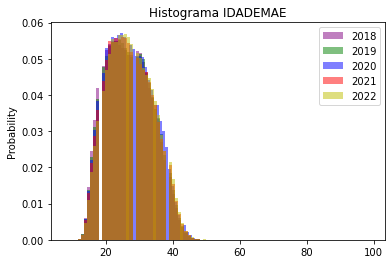

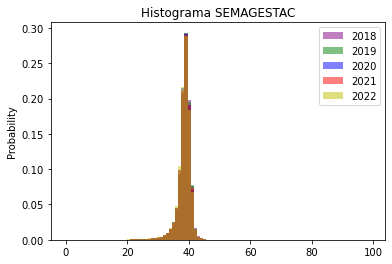

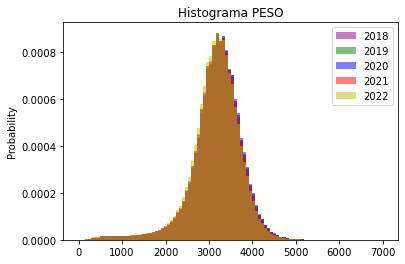

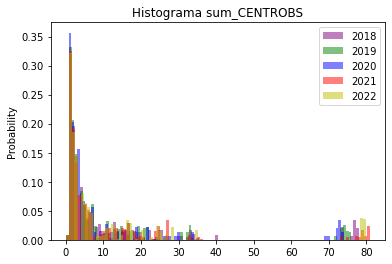

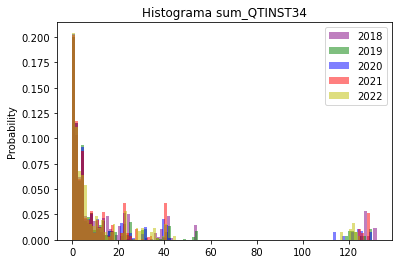

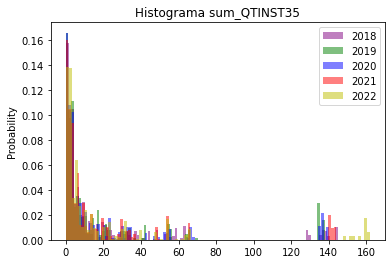

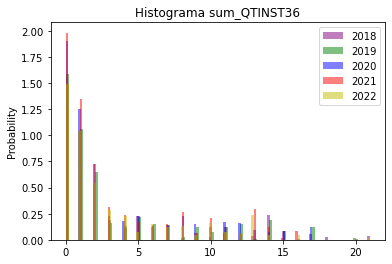

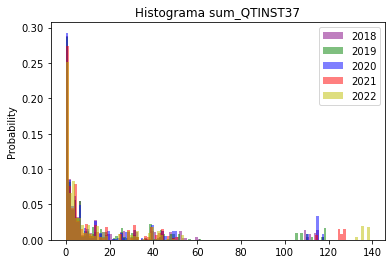

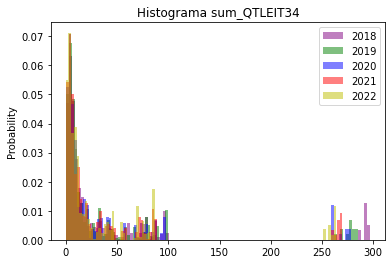

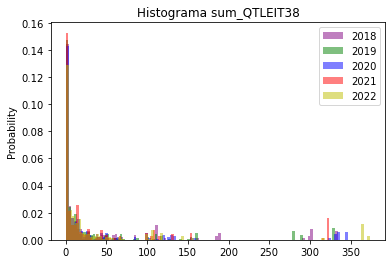

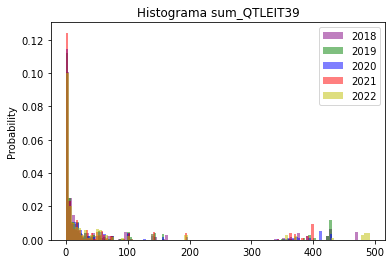

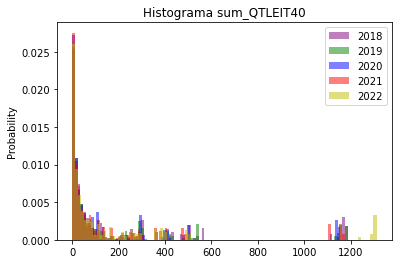

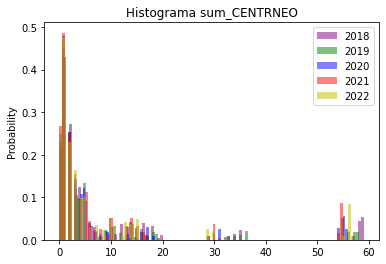

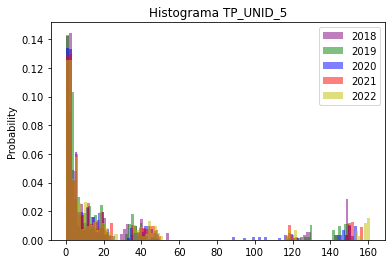

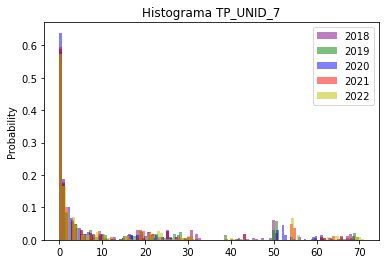

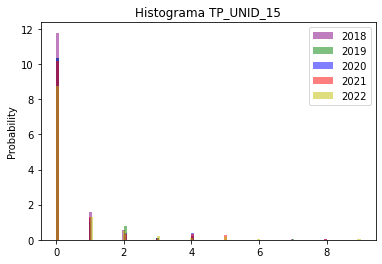

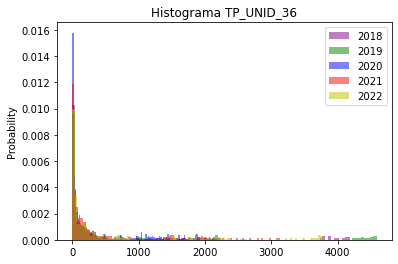

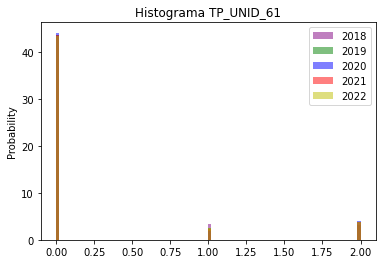

In [16]:
for i in lista_numerica:
    x0 = df.loc[df['ano_evento'] == 2018, i]
    x1 = df.loc[df['ano_evento'] == 2019, i]
    x2 = df.loc[df['ano_evento'] == 2020, i]
    x3 = df.loc[df['ano_evento'] == 2021, i]
    x4 = df.loc[df['ano_evento'] == 2022, i]

    # Normalize
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

    # Plot
    plt.figure()  # Creates a new figure for each iteration
    plt.hist(x0, **kwargs, color='purple', label='2018')
    plt.hist(x1, **kwargs, color='g', label='2019')
    plt.hist(x2, **kwargs, color='b', label='2020')
    plt.hist(x3, **kwargs, color='r', label='2021')
    plt.hist(x4, **kwargs, color='y', label='2022')
    plt.gca().set(title=f'Histograma {i}', ylabel='Probability')
    # plt.xlim(50, 75)
    plt.legend()

    # Show or save the figure here if needed
    # plt.savefig(f'histograma_{i}.png')

    plt.show()  # Show the graph

### Cause of death

In [17]:
contingency_table = pd.crosstab(index=df['CAUSABAS'], columns=df['ano_evento'])#, normalize='index')
contingency_table = contingency_table.reset_index()
contingency_table.loc[contingency_table['CAUSABAS'].isin(['P200', 'P95'])]

ano_evento,CAUSABAS,2018,2019,2020,2021,2022
74,P200,2635,2674,1842,1712,1843
141,P95,6094,6172,6634,6701,5793


### Births by municipality per year

In [18]:
df_sinasc = df.loc[df['FLAG_BASE']=='SINASC']
pd.crosstab(index=df_sinasc['evento_MUNNOMEX'], columns=df_sinasc['ano_evento'])

ano_evento,2018,2019,2020,2021,2022
evento_MUNNOMEX,,,,,
ABADIA DE GOIAS,2,5,5,2,6
ABADIA DOS DOURADOS,1,2,0,1,0
ABADIANIA,1,3,5,5,9
ABAETE,218,196,203,164,160
ABAETETUBA,2496,2133,2480,2861,2836
ABAIARA,1,1,2,5,5
ABAIRA,6,4,3,3,4
ABARE,103,96,115,107,88
ABATIA,0,2,0,1,0


# Cleaning and input data missing the dataset

### Input base SIM_DOFET

In [19]:
var_input = ['ano_evento','res_REGIAO', 'evento_REGIAO', 'IDADEMAE', 'escolaridade_mae', 'tipo_gravidez'
             , 'SEMAGESTAC', 'SEXO', 'PESO']
df_sim = df.loc[df['FLAG_BASE']=='SIM_DOFET']
df_sim_dofet = df_sim[var_input]
df_sim_dofet = df_sim_dofet.reset_index(drop=True)

In [20]:
# Acrescentando missings em Ignorados
# Substituir 'Ignorado' por NaN nas variáveis categóricas especificadas
df_sim_dofet[
    [
         'escolaridade_mae'
         , 'tipo_gravidez'
    ]
] = df_sim_dofet[
    [
         'escolaridade_mae'
        , 'tipo_gravidez'
    ]
].replace('Ignorado', np.nan)

In [21]:
df_sim_dofet.loc[
    (df_sim_dofet['IDADEMAE'] < 10) | (df_sim_dofet['IDADEMAE'] > 50) , 'IDADEMAE'
] = np.nan

In [22]:
df_sim_dofet.loc[
    (df_sim_dofet['SEMAGESTAC'] > 42) , 'SEMAGESTAC'
] = np.nan

In [23]:
# Removendo outlier em PESO
# Calcular os limites inferiores e superiores para PESO
std_peso = np.std(df['PESO'])
media_peso = np.mean(df['PESO'])
lim_inf = media_peso - (6 * std_peso)
lim_sup = media_peso + (6 * std_peso)

# Substituir valores fora do intervalo especificado por NaN na variável 'PESO'
df_sim_dofet = df_sim_dofet.loc[(df_sim_dofet['PESO'] > 0) & (df_sim_dofet['PESO'] > lim_inf) & (df_sim_dofet['PESO'] < lim_sup)]
df_sim = df_sim.loc[(df_sim['PESO'] > 0) & (df_sim['PESO'] > lim_inf) & (df_sim['PESO'] < lim_sup)]
df_sim_dofet = df_sim_dofet.reset_index(drop=True)

In [24]:
df_sim_dofet.loc[df_sim_dofet['SEXO'] == 0, 'SEXO'] = np.nan
# Substituir Inf e -Inf por NaN
#df_sim_dofet.replace([np.inf, -np.inf], np.nan, inplace=True)

In [25]:
# Contando os Missings em cada coluna
df_sim_dofet.isnull().sum()

ano_evento              0
res_REGIAO            219
evento_REGIAO         181
IDADEMAE             6609
escolaridade_mae    21733
tipo_gravidez        1112
SEMAGESTAC           6879
SEXO                 3575
PESO                    0
dtype: int64

In [26]:
# Converter variáveis categóricas para numéricas temporariamente
df_sim_dofet_encoded = pd.get_dummies(
    df_sim_dofet, columns=[
        'ano_evento'
        , 'res_REGIAO'
        , 'evento_REGIAO'
        , 'escolaridade_mae'
        , 'tipo_gravidez'
        , 'SEXO'
    ]
    , drop_first=False
)

# Imputação usando KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed_array = knn_imputer.fit_transform(df_sim_dofet_encoded)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_sim_dofet_encoded.columns)

# Reverter a codificação dummy para categorias originais mantendo os nomes originais
for col in ['ano_evento', 'res_REGIAO', 'evento_REGIAO', 'escolaridade_mae', 'tipo_gravidez', 'SEXO']:
    dummy_cols = [c for c in df_imputed.columns if c.startswith(col + '_')]
    df_imputed[col] = df_imputed[dummy_cols].idxmax(axis=1).apply(lambda x: x[len(col) + 1:])
    df_imputed.drop(dummy_cols, axis=1, inplace=True)

In [27]:
df_imputed.isnull().sum()

IDADEMAE            0
SEMAGESTAC          0
PESO                0
ano_evento          0
res_REGIAO          0
evento_REGIAO       0
escolaridade_mae    0
tipo_gravidez       0
SEXO                0
dtype: int64

In [28]:
df_sim = df_sim.reset_index(drop=True)
df_imputed = df_imputed.reset_index(drop=True)
df_sim['ano_evento'] = df_imputed['ano_evento']
df_sim['res_REGIAO'] = df_imputed['res_REGIAO']
df_sim['evento_REGIAO'] = df_imputed['evento_REGIAO']
df_sim['IDADEMAE'] = df_imputed['IDADEMAE']
df_sim['escolaridade_mae'] = df_imputed['escolaridade_mae']
df_sim['tipo_gravidez'] = df_imputed['tipo_gravidez']
df_sim['SEMAGESTAC'] = df_imputed['SEMAGESTAC']
df_sim['SEXO'] = df_imputed['SEXO']
df_sim['PESO'] = df_imputed['PESO']
df_sim['SEXO'] = df_sim['SEXO'].astype(float)
df_sim['SEXO'] = df_sim['SEXO'].astype(int)

In [29]:
# Inserir pós input
df_sim['def_sexo'] = np.where(df_sim['SEXO']==1, 'Masculino', 'Feminino')
df_sim['idade_gestacao_faixa'] = [func_categorize_idade_gest(int(round(i,0))) for i in df_sim['SEMAGESTAC']]
df_sim['idademae_faixa'] = [func_categorize_idademae(int(round(i, 0))) for i in df_sim['IDADEMAE']]
df_sim['peso_faixa'] = [func_categorize_peso(round(i,0)) for i in df_sim['PESO']]

In [30]:
df_sim.isnull().sum()

data_evento                   0
ano_evento                    0
TIPOBITO                      0
evento_MUNNOMEX             181
res_MUNNOMEX                219
evento_CAPITAL              181
res_CAPITAL                 219
evento_REGIAO                 0
res_REGIAO                    0
evento_SIGLA_UF             181
res_SIGLA_UF                219
IDADEMAE                      0
idademae_faixa                0
ESCMAE2010                10022
escolaridade_mae              0
OBITOGRAV                136711
GRAVIDEZ                    126
tipo_gravidez                 0
SEMAGESTAC                    0
idade_gestacao_faixa          0
SEXO                          0
def_sexo                      0
PESO                          0
peso_faixa                    0
OBITOPARTO                  257
def_obito_parto               0
CAUSABAS                      0
causabas_capitulo            24
causabas_categoria           24
causabas_grupo               24
causabas_subcategoria        24
FLAG_BAS

In [31]:
len(df)

13908753

In [32]:
pd.unique(df_sim['FLAG_BASE'])

array(['SIM_DOFET'], dtype=object)

In [33]:
# Apendando as bases
df = df.loc[df['FLAG_BASE']=='SINASC']
df = pd.concat([df, df_sim])

In [34]:
len(df)

13899960

In [35]:
pd.unique(df['FLAG_BASE'])

array(['SINASC', 'SIM_DOFET'], dtype=object)

In [36]:
df[df['FLAG_BASE'] == 'SIM_DOFET'].value_counts(['ano_evento'])

ano_evento
2018          28632
2021          27622
2019          27287
2020          27248
2022          25925
dtype: int64

### Remoção

In [37]:
# Removing columns with a high frequency of missings

#df_limpo = df_limpo.drop(columns=['OBITOGRAV', 'causabas_categoria', 'TIPOBITO', 'causabas_capitulo', 'CAUSABAS'
#                                  , 'def_obito_parto', 'OBITOPARTO', 'causabas_subcategoria', 'causabas_grupo'])

In [38]:
# Removing duplicates SINASC
tam_inicial = len(df)
df_sinasc = df.loc[df['FLAG_BASE']=='SINASC']
df_sim =  df.loc[df['FLAG_BASE']=='SIM_DOFET']
df_limpo = df_sinasc.drop_duplicates()
tam_depois=len(df_limpo)
print(f'Remove duplicates {tam_inicial - tam_depois} rows')

Remove duplicates 140452 rows


In [39]:
# Removendo os missing SINASC

#lista_missing_sim = [
#   'sum_CENTROBS','sum_QTINST34','sum_QTINST35','sum_QTINST36','sum_QTINST37','TP_UNID_5'
#    ,'TP_UNID_7','TP_UNID_15','TP_UNID_36','TP_UNID_61', 'res_MUNNOMEX', 'res_CAPITAL', 'res_SIGLA_UF'
#    , 'evento_MUNNOMEX', 'evento_CAPITAL', 'evento_REGIAO', 'evento_SIGLA_UF', 'causabas_capitulo', 'causabas_categoria'
#    , 'causabas_grupo', 'causabas_subcategoria'
#]

lista_missing_sinasc = [
    'ESCMAE2010','SEMAGESTAC','PESO','IDADEMAE','sum_CENTROBS','sum_QTINST34','sum_QTINST35','sum_QTINST36','sum_QTINST37'
    ,'sum_QTLEIT34','sum_QTLEIT38','sum_QTLEIT39','sum_QTLEIT40','sum_CENTRNEO','TP_UNID_5'
    ,'TP_UNID_7','TP_UNID_15','TP_UNID_36','TP_UNID_61', 'GRAVIDEZ', 'res_MUNNOMEX', 'res_CAPITAL', 'res_SIGLA_UF'
    , 'evento_MUNNOMEX', 'evento_CAPITAL', 'evento_REGIAO', 'evento_SIGLA_UF'
]
tam_antes = len(df_limpo)
#df_limpo_sim = df_limpo_sim.dropna(subset = lista_missing_sim)
df_limpo = df_limpo.dropna(subset = lista_missing_sinasc)
df_limpo = df_limpo.reset_index(drop=True)
tam_depois=len(df_limpo)
print(f'Remove missing {tam_antes - tam_depois} rows')

Remove missing 339719 rows


In [40]:
# Removendo missing SIM, somente nas colunas 'CNES'
lista_missing_sim = [
   'sum_CENTROBS','sum_QTINST34','sum_QTINST35','sum_QTINST36','sum_QTINST37','TP_UNID_5'
    ,'TP_UNID_7','TP_UNID_15','TP_UNID_36','TP_UNID_61'
]

tam_sim = len(df_sim)
df_sim = df_sim.dropna(subset = lista_missing_sim)
df_sim = df_sim.reset_index(drop=True)
tam_depois_sim = len(df_sim)
print(f'Remove missing {tam_sim - tam_depois_sim} rows')

Remove missing 184 rows


In [41]:
# Remove ignored class SINASC
tam_antes = len(df_limpo) 
df_limpo['evento_MUNNOMEX'] = df_limpo['evento_MUNNOMEX'].astype(str).fillna('IGNORADO')
df_limpo = df_limpo.loc[~df_limpo['evento_MUNNOMEX'].str.contains('IGNORADO')]
tam_depois=len(df_limpo)
print(f'Remove ignored evento_MUNNOMEX {tam_antes - tam_depois} rows')

Remove ignored evento_MUNNOMEX 0 rows


In [42]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[~df_limpo['res_MUNNOMEX'].str.contains('IGNORADO')]
tam_depois=len(df_limpo)
print(f'Remove ignored res_MUNNOMEX {tam_antes - tam_depois} rows')

Remove ignored res_MUNNOMEX 337 rows


In [43]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['idademae_faixa']!='Ignorado']
tam_depois=len(df_limpo)
print(f'Remove ignored idademae_faixa {tam_antes - tam_depois} rows')

Remove ignored idademae_faixa 0 rows


In [44]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['ESCMAE2010']!=9]
tam_depois=len(df_limpo)
print(f'Remove ignored ESCMAE2010 {tam_antes - tam_depois} rows')

Remove ignored ESCMAE2010 62676 rows


In [45]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['GRAVIDEZ']!=9]
tam_depois=len(df_limpo)
print(f'Remove ignored GRAVIDEZ {tam_antes - tam_depois} rows')

Remove ignored GRAVIDEZ 6611 rows


In [46]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['idade_gestacao_faixa']!='Ignorado']
tam_depois=len(df_limpo)
print(f'Remove ignored idade_gestacao_faixa {tam_antes - tam_depois} rows')

Remove ignored idade_gestacao_faixa 101177 rows


In [47]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['SEXO']!=0]
tam_depois=len(df_limpo)
print(f'Remove ignored SEXO {tam_antes - tam_depois} rows')

Remove ignored SEXO 2044 rows


In [48]:
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['peso_faixa']!='Ignorado']
tam_depois=len(df_limpo)
print(f'Remove ignored peso_faixa {tam_antes - tam_depois} rows')

Remove ignored peso_faixa 0 rows


In [49]:
# Mother's age
# Remover somente em SINASC
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[(df_limpo['IDADEMAE']>=10) & (df_limpo['IDADEMAE']<=50)]
tam_depois=len(df_limpo)
print(f'Remove IDADEMAE <10 or >50 {tam_antes - tam_depois} rows')

Remove IDADEMAE <10 or >50 1403 rows


In [50]:
# Weight
std_peso = np.std(df['PESO'])
media_peso = np.mean(df['PESO'])
lim_inf = media_peso - (6 * std_peso)
lim_sup = media_peso + (6 * std_peso)
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['PESO']>0]
df_limpo = df_limpo.loc[(df_limpo['PESO']>=lim_inf) & (df_limpo['PESO']<=lim_sup)]
tam_depois=len(df_limpo)
print(f'Remove PESO 6 std {tam_antes - tam_depois} rows')

Remove PESO 6 std 57 rows


In [51]:
# Weeks of pregnancy less than 22 are not considered deaths, but rather miscarriages. SIM e SINASC
df_limpo = pd.concat([df_limpo, df_sim])
tam_antes = len(df_limpo)
df_limpo = df_limpo.loc[df_limpo['idade_gestacao_faixa']!='menor_22']
tam_depois=len(df_limpo)
print(f'Remove idade_gestacao_faixa menor_22 {tam_antes - tam_depois} rows')

Remove idade_gestacao_faixa menor_22 17508 rows


In [52]:
tam_depois = len(df)
print(f'Total remove {tam_inicial - tam_depois} rows')

Total remove 0 rows


In [53]:
df_limpo = df_limpo.reset_index(drop=True)

In [54]:
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13364506 entries, 0 to 13364505
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   data_evento            object 
 1   ano_evento             object 
 2   TIPOBITO               float64
 3   evento_MUNNOMEX        object 
 4   res_MUNNOMEX           object 
 5   evento_CAPITAL         object 
 6   res_CAPITAL            object 
 7   evento_REGIAO          object 
 8   res_REGIAO             object 
 9   evento_SIGLA_UF        object 
 10  res_SIGLA_UF           object 
 11  IDADEMAE               float64
 12  idademae_faixa         object 
 13  ESCMAE2010             float64
 14  escolaridade_mae       object 
 15  OBITOGRAV              float64
 16  GRAVIDEZ               float64
 17  tipo_gravidez          object 
 18  SEMAGESTAC             float64
 19  idade_gestacao_faixa   object 
 20  SEXO                   int64  
 21  def_sexo               object 
 22  PESO            

In [55]:
df_limpo[df_limpo['FLAG_BASE'] == 'SIM_DOFET'].value_counts(['ano_evento'])

ano_evento
2018          26602
2021          25336
2019          25289
2020          25086
2022          23367
dtype: int64

In [56]:
df_limpo.to_csv('base_limpa/base_unificada_limpa_com_input.csv', index=False)